# Analysis

It seems like for "o" Praat gets the resonance freqs $F$ way wrong, and the algorithm gets too constrained by that.

Actual resonance freqs = 570, 840, 2410 (Table 1 in the Alku 2019 paper)... contains two low poles.

Because our prior $p(x|F)$ where $F$ is the Praat estimate constrains too much, we estimate the low pole at about 650 Hz, and the low freq variation in the signal coming from the two true poles can only be generated with that one pole.

So the second pole's effect has to be emulated by using additional low frequency wiggles in the GF. This causes the signal to wiggle during the closed period. And as such our GF and formant estimates are way off, despite very highs SNR ~ 55 dB.

## Solution #1

We remove Praat's estimates to get $p(x|F) \rightarrow p(x)$, but $p(x)$ is still very shy of low $x_2$ values for the AP(3) model... they are typicall ~1500 Hz, so basically the same problem arises.

So we don't do this one.

## Solution #2

As a sanity check we condition on the true values (i.e. $F \rightarrow F_\text{true}) to shake $p(x)$ looser and see what happens.

**And indeed**: the negative GF is now largely gone! Our analysis is correct.

In [1]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util
from inv import model
from inv import process

2024-01-07 15:57:24.294555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-07 15:57:25.311879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-07 15:57:25.312025: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-07 15:57:25.312038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [2]:
path = __datadir__("OPENGLOT/RepositoryI/Vowel_O/O_normal_200Hz.wav")

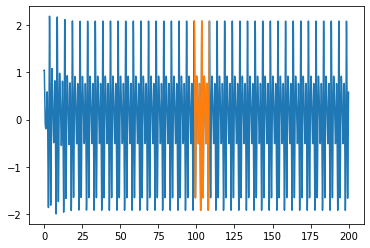

In [5]:
from scipy.io import wavfile
fs, rawdata = wavfile.read(path)

data = process.process_data(rawdata, fs, max_NP=3)

plot(data['fullt'], data['fulld'])
plot(data['t'], data['d'])

(array([ 98.6, 103.6, 108.6]),
 array([[          nan,           nan,           nan],
        [ 585.08020774, 2364.10460151, 2958.49149314],
        [ 585.07962237, 2364.10900539, 2958.51707931]]))

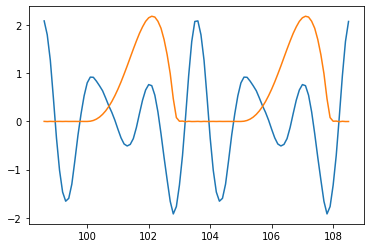

In [8]:
plot(data['t'], data['d'])
plot(data['t'], data['aux'])

data['pulse_estimate'], data['F_estimate']

[Memory]78.8s, 1.3min   : Loading get_aplawd_training_pairs_subset...


[Memory]96.7s, 1.6min   : Loading run_nested...
[Memory]98.9s, 1.6min   : Loading run_nested...
[Memory]101.0s, 1.7min  : Loading run_nested...
[Memory]103.8s, 1.7min  : Loading run_nested...
NP = 3
Number of data points: 100
Number of model dimensions: 35


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': True},
 AllPoleFilter(3))

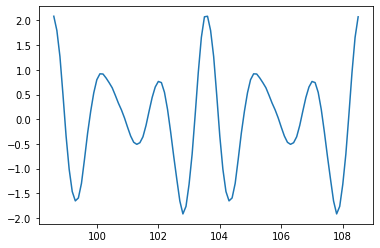

In [9]:
from inv import model
from inv import process
from vtr.prior import filter
import jax

source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.AP(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

ftril = process.get_source_amplitudes_tril(
    data['NP'], source_config['kernel_M']
)

hyper = dict(
    meta = dict(
        noiseless_estimates = False,
        bf = constants.BOUNDARY_FACTOR,
        rho = .5, # Peak picking
        inference_method = "nested_sampling",
        inference_method_options = {}
    ),
    ftril = ftril,
    data = data,
    source = source_config,
    filter = vtfilter
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

In [10]:
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())
theta, prior.log_prob(theta)

[Memory]115.1s, 1.9min  : Loading get_aplawd_training_pairs_subset...
[Memory]116.0s, 1.9min  : Loading posterior_of_fitted_lf_values...
[Memory]116.2s, 1.9min  : Loading run_nested...
[Memory]116.3s, 1.9min  : Loading get_aplawd_training_pairs_subset...
[Memory]121.5s, 2.0min  : Loading posterior_of_fitted_TFB_values...
[Memory]121.7s, 2.0min  : Loading run_nested...
[Memory]121.8s, 2.0min  : Loading get_vtrformants_training_data...
[Memory]131.5s, 2.2min  : Loading run_nested...
[Memory]132.7s, 2.2min  : Loading run_nested...
[Memory]134.0s, 2.2min  : Loading run_nested...
[Memory]135.3s, 2.3min  : Loading run_nested...
[Memory]135.3s, 2.3min  : Loading get_vtrformants_training_data...


({'noise_sigma': DeviceArray(0.38892612, dtype=float64),
  'delta': DeviceArray(0.43753073, dtype=float64),
  'source': DeviceArray([[1.1392227 , 0.09447348, 4.69477055, 0.99578405],
               [1.05603721, 0.09414797, 4.78310218, 0.99625376],
               [1.02041344, 0.08797956, 5.06733519, 0.99640756]],            dtype=float64),
  'filter': DeviceArray([[ 531.21699928, 2114.68283053, 2547.58694659,   88.03591324,
                 166.53546724,  127.64579378],
               [ 513.98301439, 2144.09050859, 2576.21151128,   84.69186225,
                 172.02255407,  128.95848642],
               [ 504.60681805, 2176.18083532, 2625.76086413,   83.61987446,
                 180.5962526 ,  135.35305093]], dtype=float64),
  'g': DeviceArray([[-0.19423835],
               [-0.74059791],
               [-0.01641798]], dtype=float64)},
 DeviceArray(-57.18792586, dtype=float64))

Show the possible model functions $f(t;\theta)$ for a sampled $\theta$. We need to find a $\theta$ for which **most** -- not just a few -- of these samples are close to the data. **This is Bayesian regularization in action.**

We can see that the general amplitude magnitude is reasonable, although for larger $K$ for PZ and $N_P$ it may take more samples to hit O(1) range. This is because of interpitch-period correlations and the heavier tails of the energy distribution of the PZ model.

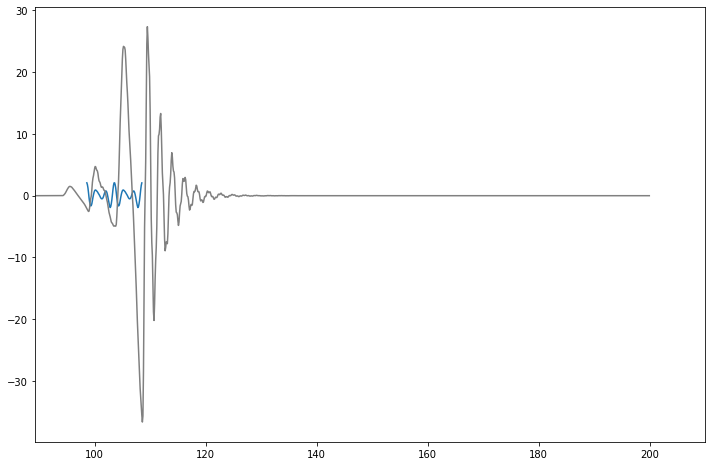

In [75]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True
)

plot(hyper['data']['t'], hyper['data']['d'])

nsamp = 1
for _ in range(nsamp):
    w = model.randf(hyper)
    f = R @ w
    plot(hyper['data']['fullt'], f, color='grey', alpha=1/sqrt(nsamp))

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

setxlim(f)

klatt.play(hyper['data']['t'], f)

We can see the correlations in the $f$ amplitudes well.

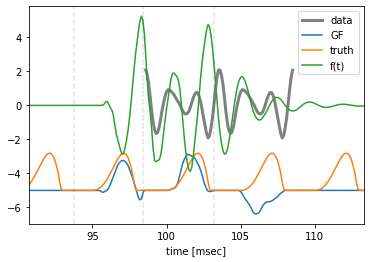

In [40]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
offset = model.get_offset(delta, theta_source, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True, correlatef=False
)

R_gfd = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, 
    convolve=False, integrate=True, correlatef=False
)

w = model.randf(hyper)

plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)

plot(hyper['data']['fullt'], R_gfd @ w - 5, label="GF")
plot(hyper['data']['fullt'], hyper['data']['fullaux'] - 5, label="truth")

plot(hyper['data']['fullt'], R @ w, label="f(t)")
for tp in offset: axvline(tp, ls="--", color="black", alpha=.1)
xlabel("time [msec]")
setxlim(R_gfd @ w)
legend();

## Test NS algorithm

In [19]:
import dynesty
import scipy
from inv import model

theta_bijector = model.theta_trajectory_bijector(hyper)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper)
ndim

[Memory]370.1s, 6.2min  : Loading posterior_of_fitted_lf_values...
[Memory]370.2s, 6.2min  : Loading run_nested...
[Memory]370.3s, 6.2min  : Loading posterior_of_fitted_TFB_values...
[Memory]370.3s, 6.2min  : Loading run_nested...


35

In [42]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

(DeviceArray(-2076.15582859, dtype=float64),
 {'noise_sigma': DeviceArray(0.09632576, dtype=float64),
  'delta': DeviceArray(0.03492736, dtype=float64),
  'source': DeviceArray([[3.81329073, 0.31699418, 4.65190122, 0.87025548],
               [4.26857952, 0.36572943, 4.79095595, 0.9045476 ],
               [3.48623804, 0.31163179, 4.77612978, 0.89418227]],            dtype=float64),
  'filter': DeviceArray([[ 471.18249185, 2131.45901001, 2441.7619696 ,   83.59588217,
                  39.9569405 ,   85.91897779],
               [ 471.94942227, 2188.43105111, 2449.33585275,   87.41233073,
                  42.59129446,   89.65247318],
               [ 479.58459152, 2270.80126725, 2465.34409741,   88.6010307 ,
                  45.31708559,   94.62162091]], dtype=float64),
  'g': DeviceArray([[-0.00210566],
               [ 0.48886933],
               [ 0.30722772]], dtype=float64)})

In [44]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 5.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

# Could use 10% stopping criteria as in Petrosyan+ 2023
sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=3*ndim, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

5538it [7:23:52,  4.81s/it, +105 | bound: 195 | nc: 1 | ncall: 1224235 | eff(%):  0.461 | loglstar:   -inf < 234.299 <    inf | logz: 183.953 +/-  0.643 | dlogz:  0.001 >  0.114]


Summary
nlive: 105
niter: 5538
ncall: 1224130
eff(%):  0.461
logz: 183.953 +/-  0.715


None

'Information (bans)'

18.207518335163073

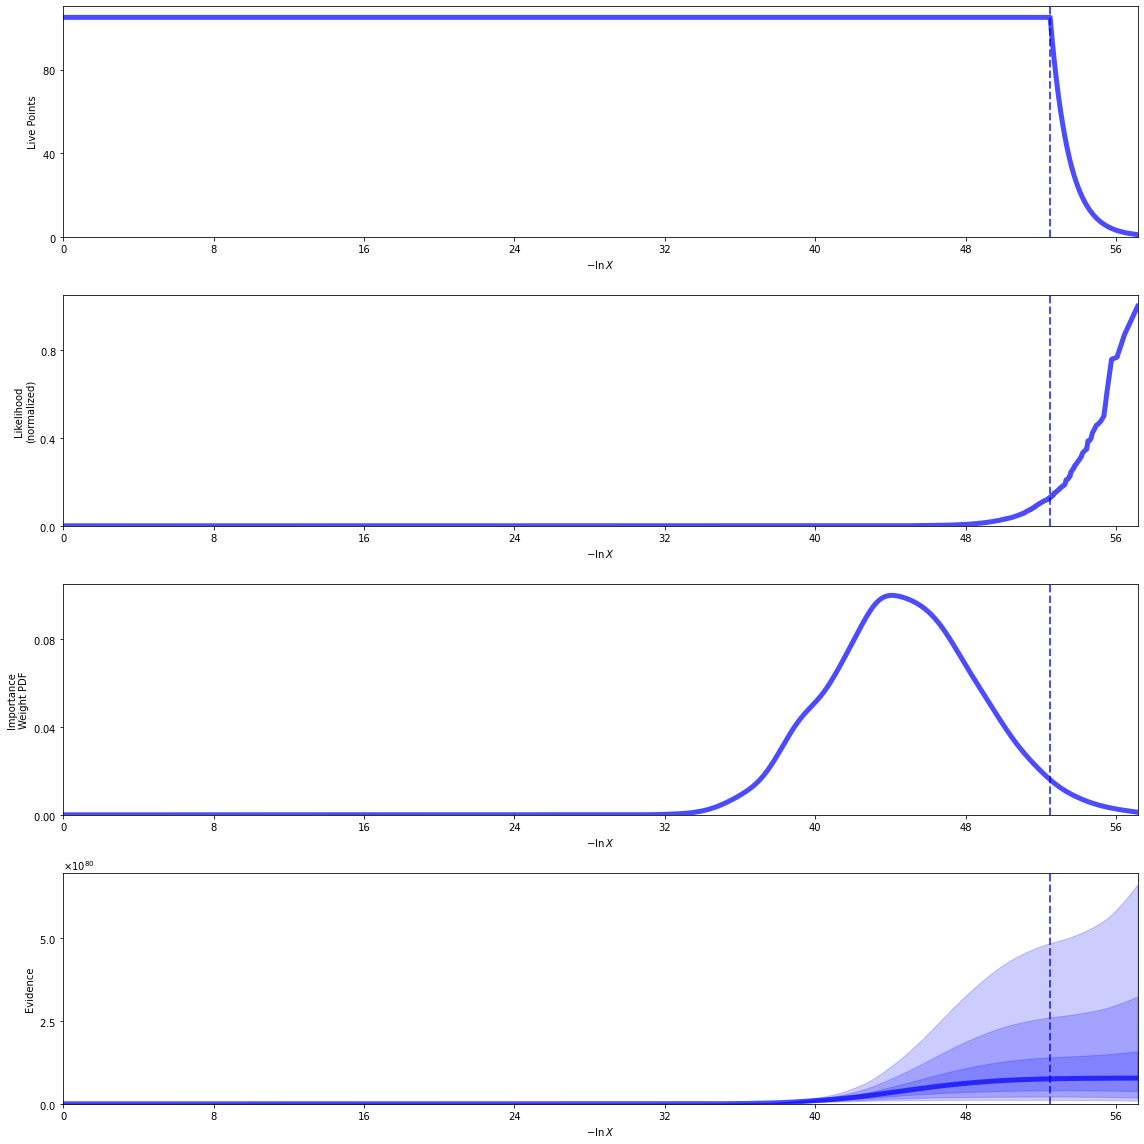

Quantiles:
$x_{1}$ [(0.025, -6.320980462987312), (0.5, -5.442380108642081), (0.975, -4.637511987120223)]
Quantiles:
$x_{2}$ [(0.025, -1.3706880558661283), (0.5, -0.513435927155537), (0.975, 0.1942448724246563)]
Quantiles:
$x_{3}$ [(0.025, -1.9560442131676448), (0.5, -1.3599160679236282), (0.975, -0.8949097836564937)]
Quantiles:
$x_{4}$ [(0.025, -2.1022199556952916), (0.5, -0.19612359125290832), (0.975, 1.5428323459277975)]
Quantiles:
$x_{5}$ [(0.025, -0.7128768832687584), (0.5, 0.2283083139912626), (0.975, 1.3935024405472891)]
Quantiles:
$x_{6}$ [(0.025, -0.41081876349188745), (0.5, 0.10074691617031338), (0.975, 0.7519186466589518)]
Quantiles:
$x_{7}$ [(0.025, -1.39800922284888), (0.5, 0.22147875581412774), (0.975, 1.727584753441025)]
Quantiles:
$x_{8}$ [(0.025, -0.9258032032253058), (0.5, 0.09207926712645317), (0.975, 1.343952458441323)]
Quantiles:
$x_{9}$ [(0.025, -0.5276140327043002), (0.5, -0.023939512419688856), (0.975, 0.5104136367854122)]
Quantiles:
$x_{10}$ [(0.025, -1.01932527

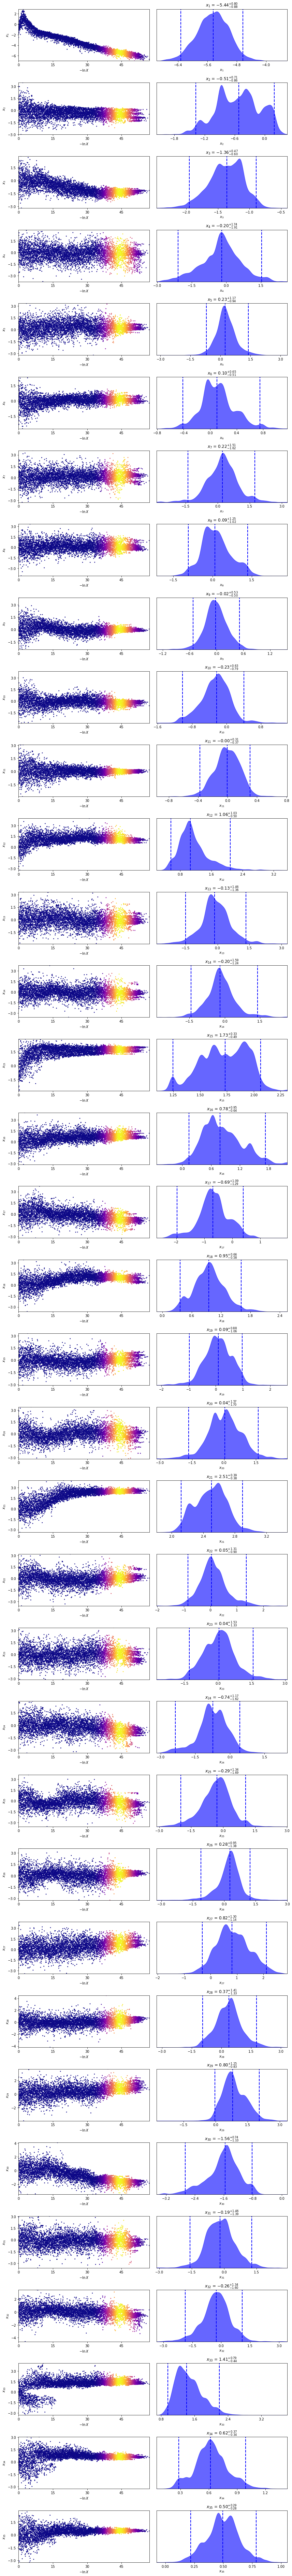

In [46]:
util.dyplot(results, runplot=True, traceplot=True, cornerplot=False)

In [73]:
@jax.jit
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

0	log L = 229.01832839321924	SNR [dB] = 58.12449670641706
1	log L = 220.5227355765415	SNR [dB] = 57.64179812254962
2	log L = 225.290887736941	SNR [dB] = 56.8150041612589
3	log L = 230.56942495444952	SNR [dB] = 57.633156656160565
4	log L = 218.82622877224202	SNR [dB] = 56.14018406506797


DeviceArray(0.13204119, dtype=float64)

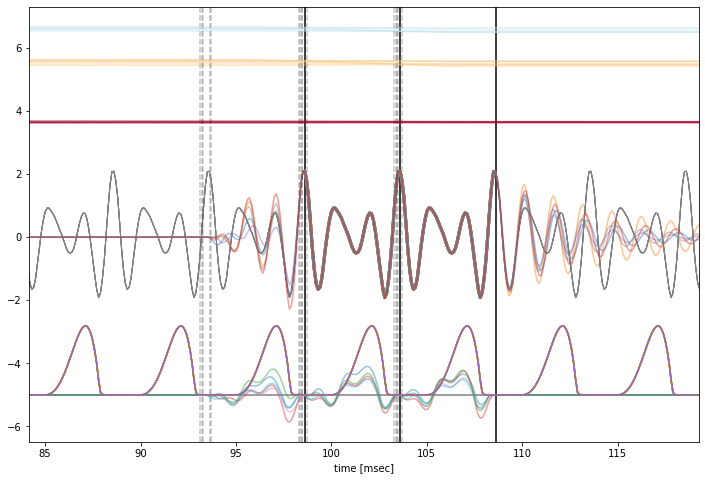

In [49]:
nsamp = 5

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    plot(hyper['data']['fullt'], hyper['data']['fullaux'] - 5, label="truth")
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf, .1)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

In [50]:
model.unpack_theta(theta, hyper)

(DeviceArray(0.00155952, dtype=float64),
 DeviceArray(0.13204119, dtype=float64),
 {'Oq': DeviceArray([0.95975085, 0.97667063, 0.97045866], dtype=float64),
  'T': DeviceArray([5.20882675, 4.97787019, 4.97726347], dtype=float64),
  'r': DeviceArray([0.12949483, 0.12510169, 0.15282946], dtype=float64),
  'var_sigma': DeviceArray([0.84981703, 0.79922722, 0.94651667], dtype=float64)},
 {'g': DeviceArray([[1.97051865],
               [1.86636177],
               [1.59989681]], dtype=float64),
  'x': DeviceArray([[ 661.85763806, 2625.04939068, 3635.15096291],
               [ 645.75738948, 2534.81750178, 3574.68021462],
               [ 633.27817152, 2418.87260731, 3496.4538032 ]],            dtype=float64),
  'y': DeviceArray([[ 68.41224508, 532.33430609, 137.98445342],
               [ 67.09598088, 503.14746759, 126.04987669],
               [ 65.99933699, 475.25214592, 113.15103619]], dtype=float64)})

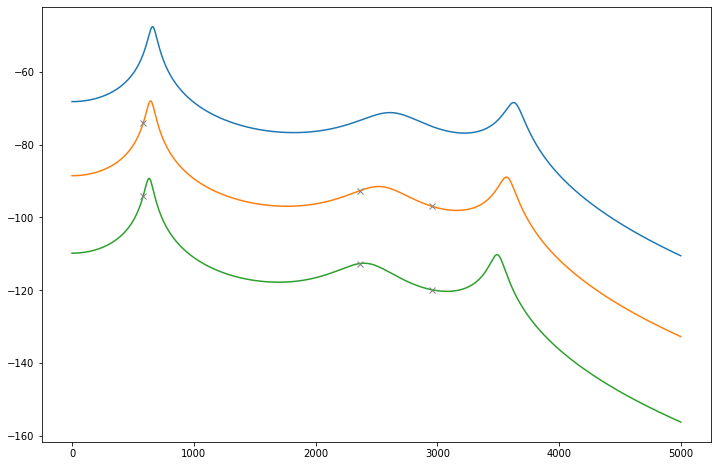

In [51]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

# Given the true formant estimates, not Praat's

In [54]:
F_true = np.vstack([[570., 840., 2410.]]*3)

F_true, data['F_estimate']

(array([[ 570.,  840., 2410.],
        [ 570.,  840., 2410.],
        [ 570.,  840., 2410.]]),
 array([[          nan,           nan,           nan],
        [ 585.08020774, 2364.10460151, 2958.49149314],
        [ 585.07962237, 2364.10900539, 2958.51707931]]))

In [55]:
# Impose truth formant estimates
new_data = data.copy()
new_data['F_estimate'] = F_true

new_hyper = process.hyper_variation(hyper, data=new_data)

In [56]:
theta_bijector = model.theta_trajectory_bijector(new_hyper)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, new_hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(new_hyper)
ndim

[Memory]1454.9s, 24.2min: Loading posterior_of_fitted_lf_values...
[Memory]1454.9s, 24.2min: Loading run_nested...
[Memory]1455.0s, 24.2min: Loading posterior_of_fitted_TFB_values...
[Memory]1455.0s, 24.3min: Loading run_nested...


35

In [60]:
xs = []

for i in range(100):
    w = ptform(rand(ndim))
    theta = theta_bijector.forward(w)
    xs.append(theta['filter'][0,:2])

xs = np.array(xs)
xs

array([[ 542.4628587 ,  886.53806881],
       [ 526.2576435 ,  880.72220333],
       [ 588.80991568,  977.39159693],
       [ 539.94725921, 1020.45570386],
       [ 577.10721421,  804.00704866],
       [ 633.47749313, 1035.74365486],
       [ 554.94146687,  808.95821607],
       [ 685.93412932, 1097.41657489],
       [ 588.45052706, 1130.0834467 ],
       [ 645.80792909, 1014.20804541],
       [ 500.12712839,  893.0477264 ],
       [ 539.09409955,  795.92742001],
       [ 673.71648631, 1207.45014468],
       [ 600.75814355,  955.4025634 ],
       [ 531.89310091,  966.17339981],
       [ 504.76516202,  872.2238779 ],
       [ 611.40379278,  949.60350083],
       [ 571.69122782,  838.17801993],
       [ 658.78276824,  838.87486824],
       [ 538.73581921,  880.55234345],
       [ 635.46890313,  961.65184077],
       [ 532.26163954,  831.41834688],
       [ 600.17079649,  985.09619058],
       [ 506.67957992,  851.92594826],
       [ 566.90486778,  883.92215488],
       [ 556.04872006,  9

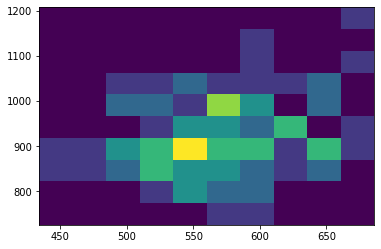

In [61]:
hist2d(xs[:,0], xs[:,1]);

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 5.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

# Could use 10% stopping criteria as in Petrosyan+ 2023
sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=3*ndim, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

6717it [8:20:35,  4.47s/it, +105 | bound: 242 | nc: 1 | ncall: 1394173 | eff(%):  0.489 | loglstar:   -inf < 226.208 <    inf | logz: 164.689 +/-  0.703 | dlogz:  0.001 >  0.114]


Summary
nlive: 105
niter: 6717
ncall: 1394068
eff(%):  0.489
logz: 164.689 +/-  0.777


None

'Information (bans)'

21.593827274345276

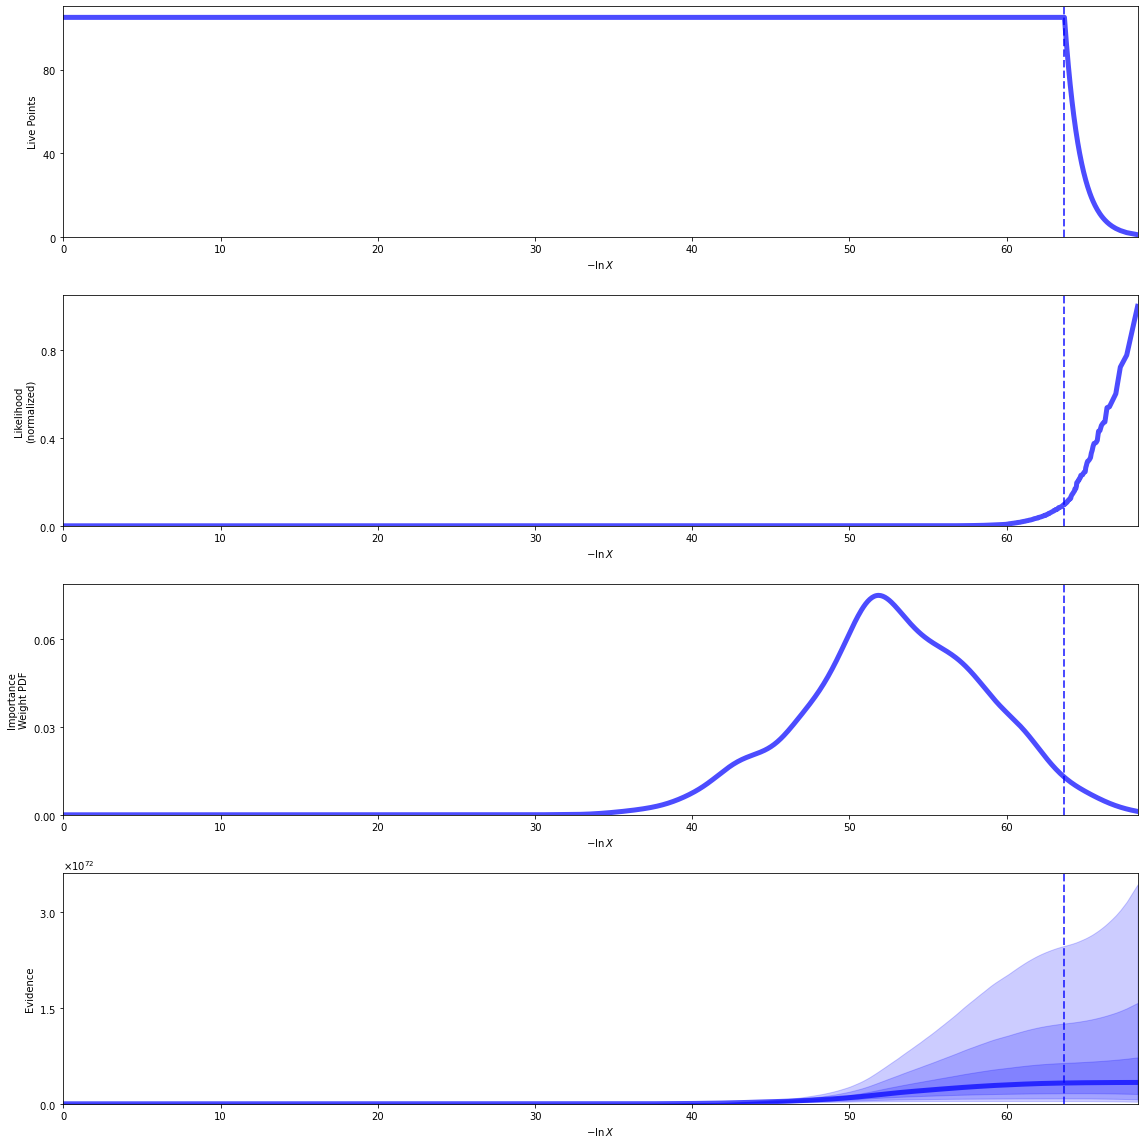

Quantiles:
$x_{1}$ [(0.025, -2.5119572554038734), (0.5, -2.306574377027299), (0.975, -2.0953060867585456)]
Quantiles:
$x_{2}$ [(0.025, 1.0019221495024133), (0.5, 2.0410550981205398), (0.975, 3.220882734371093)]
Quantiles:
$x_{3}$ [(0.025, -1.8959724939014748), (0.5, -1.3920809332924404), (0.975, -1.0657857390406198)]
Quantiles:
$x_{4}$ [(0.025, -1.6273419405933884), (0.5, -0.37225711442520143), (0.975, 0.592378521986898)]
Quantiles:
$x_{5}$ [(0.025, -2.3783068013808455), (0.5, -0.8828767867550614), (0.975, 0.22189871393135804)]
Quantiles:
$x_{6}$ [(0.025, -3.291959825411995), (0.5, -2.5872216007994755), (0.975, -1.6031574914547797)]
Quantiles:
$x_{7}$ [(0.025, -0.9480854506539393), (0.5, 0.3813438119841), (0.975, 1.9000011973934043)]
Quantiles:
$x_{8}$ [(0.025, -1.2048150369048318), (0.5, 0.0662257286189777), (0.975, 1.166716070801515)]
Quantiles:
$x_{9}$ [(0.025, -0.42004965938407257), (0.5, 0.5544321774192056), (0.975, 1.4815252255050542)]
Quantiles:
$x_{10}$ [(0.025, -1.904567871230

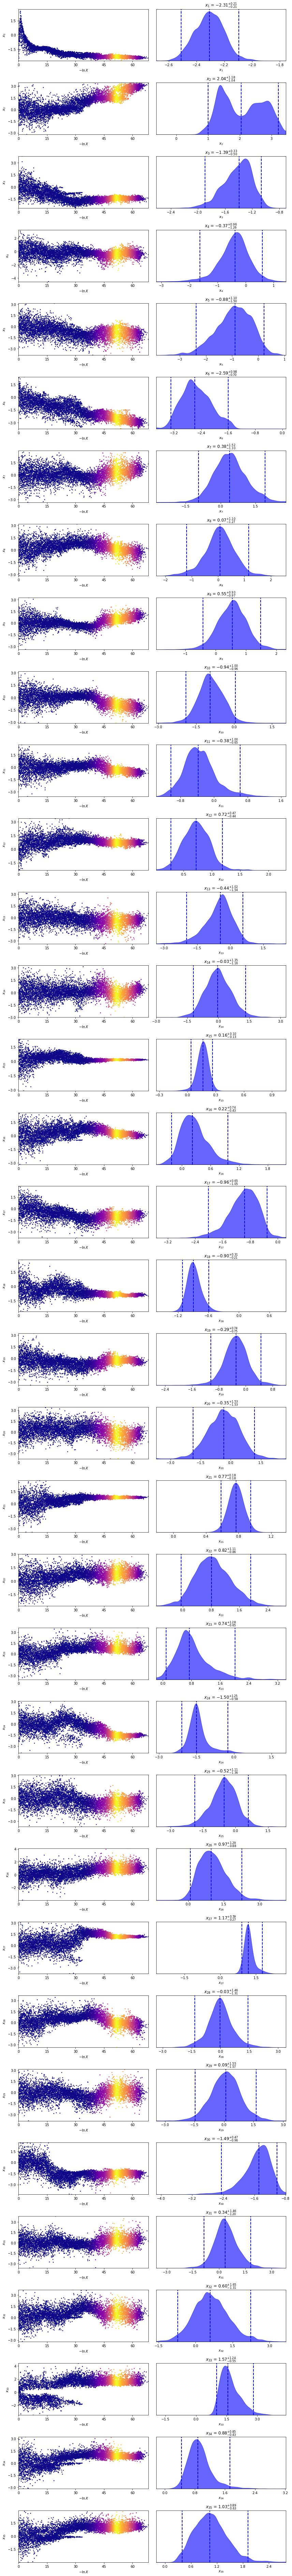

In [63]:
util.dyplot(results, runplot=True, traceplot=True, cornerplot=False)

0	log L = 214.74868502207897	SNR [dB] = 39.20943784182604
1	log L = 212.97378711548413	SNR [dB] = 38.688428995500544
2	log L = 210.13158741623914	SNR [dB] = 39.60424729139717
3	log L = 206.7275311171441	SNR [dB] = 39.5794377133197
4	log L = 202.8981337455715	SNR [dB] = 39.32633366450872
5	log L = 203.12653149963796	SNR [dB] = 37.110382489606664
6	log L = 207.95705226189585	SNR [dB] = 39.17801663627554
7	log L = 219.1048436974745	SNR [dB] = 39.820421263462535
8	log L = 213.0682343494155	SNR [dB] = 39.67806222346052
9	log L = 199.99476292350602	SNR [dB] = 38.60380291511369


DeviceArray(0.54929411, dtype=float64)

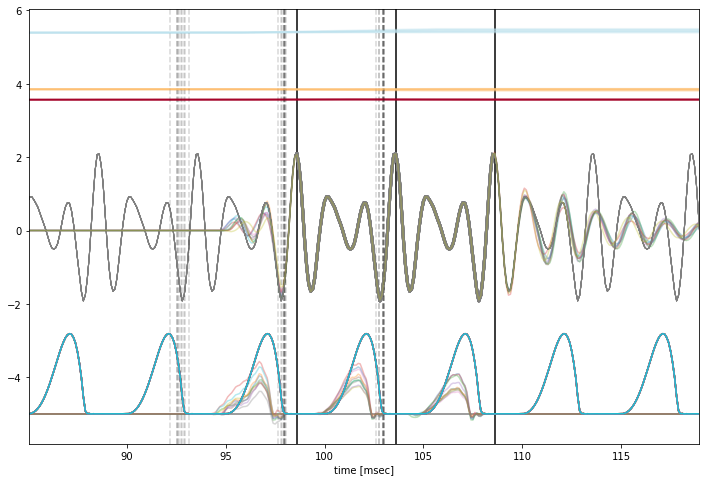

In [77]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in new_hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, new_hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, new_hyper)
    offset = model.get_offset(delta, theta_source, new_hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, new_hyper, convolve=True
    )

    f_mean = lstsq(R, new_hyper['data']['d'], noise_sigma**2)

    new_hyper2 = process.hyper_fullt(new_hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, new_hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, new_hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(new_hyper['data']['fullt'], new_hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(new_hyper['data']['t'], new_hyper['data']['d'], color="grey", label="data", lw=3)
    plot(new_hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(new_hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    plot(new_hyper['data']['fullt'], new_hyper['data']['fullaux'] - 5, label="truth")
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf, .1)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            new_hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            new_hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/new_hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

Note that the GCI estimates of BNGIF are quasi perfect, as opposed to Praat's pulse estimates.

In [78]:
model.unpack_theta(theta, new_hyper)

(DeviceArray(0.01174383, dtype=float64),
 DeviceArray(0.54929411, dtype=float64),
 {'Oq': DeviceArray([0.72995832, 0.70509843, 0.74565655], dtype=float64),
  'T': DeviceArray([4.92490208, 4.95716215, 5.09680934], dtype=float64),
  'r': DeviceArray([0.02904517, 0.0272171 , 0.02601808], dtype=float64),
  'var_sigma': DeviceArray([0.48325965, 0.44578989, 0.38778476], dtype=float64)},
 {'g': DeviceArray([[2.12963512],
               [2.34504225],
               [3.12884442]], dtype=float64),
  'x': DeviceArray([[ 560.31601124,  857.49103493, 2387.05756452],
               [ 581.35390348,  847.38888247, 2407.74120294],
               [ 585.22772857,  856.90127714, 2437.09943269]],            dtype=float64),
  'y': DeviceArray([[ 69.22871778, 148.49564422,  55.5240733 ],
               [ 70.10609723, 157.48087583,  56.61763824],
               [ 71.85630367, 160.36869032,  61.19559268]], dtype=float64)})

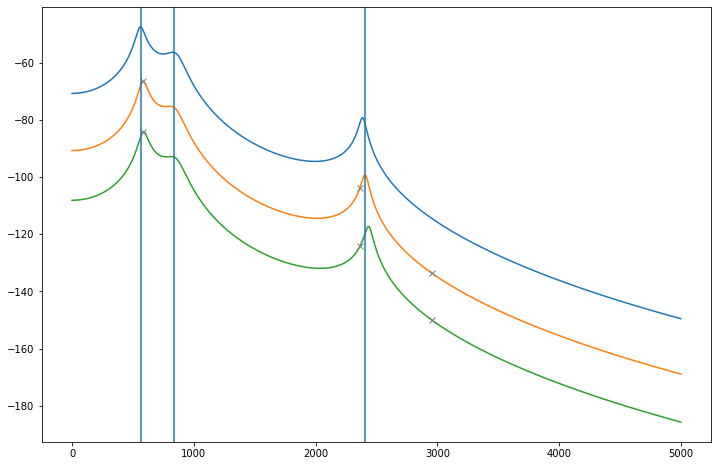

In [81]:
f = constants.spectrum_frequencies()

powers = jax.vmap(new_hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

for F in F_true[0,:]:
    axvline(F)

Praat estimates are way off; ours are perfect! Ofcourse we centered our prior on the true values, but this was just to ensure proper support of the prior $p(x)$.